# Import

In [1]:

import os
import sys
import numpy as np
import matplotlib.pyplot as pl
from scipy.interpolate import interp1d
import pandas as pd
from configparser import NoOptionError
from math import radians, degrees, sqrt, cos, sin, atan2, atan, pi, acos, exp
import configparser
import matplotlib
import matplotlib.pyplot as plt
%matplotlib widget
from tqdm.notebook import tqdm

from scipy import optimize
from configparser import SafeConfigParser


# Define blade element momentum theory functions (modified version of pyBEMT)

In [2]:
class Airfoil:
    """
    Class for storing airfoil drag and lift coefficients. Should be initialized using 
    the load_airfoil() function.
    """

    def __init__(self):
        self.name = None
        self.alpha_ = None
        self.Cl_ = None
        self.Cd_ = None
        self.Cl_func = None
        self.Cd_func = None
        self.zero_lift = 0.0
        
    def _normalize_angle(self, alpha):
        """
        Ensure that the angle fulfils :math:`\\pi < \\alpha < \\pi`

        :param float alpha: Angle in radians
        :return: Normalized angle
        :rtype: float
        """

        return atan2(sin(alpha), cos(alpha))
    
    def Cd(self, alpha): 
        """
        Provide drag coefficent for a given angle of attack.

        :param float alpha: Angle in radians
        :return: Drag coefficient
        :rtype: float
        """
        # NB! The stored data uses degrees for the angle
        return self.Cd_func(-self.zero_lift + degrees(self._normalize_angle(alpha))) # alppha[rad]

    def Cl(self, alpha): # NB! The stored data uses degrees for the angle
        """
        Provide drag coefficent for a given angle of attack.

        :param float alpha: Angle in radians
        :return: Drag coefficient
        :rtype: float
        """
        
        return self.Cl_func(-self.zero_lift + degrees(self._normalize_angle(alpha)))

    def plot(self, color='k'):
        """
        Plot lift and drag coefficients.

        :param string color: Matplotlib color key. Default value is k, i.e. black.
        """

        pl.plot(self.alpha_, self.Cl_, color + '-')
        pl.plot(self.alpha_, self.Cd_, color + '--')
        pl.title('Airfoil characteristics for ' + self.name)
        pl.xlabel('Angle of attack')
        pl.ylabel('Drag and lift coefficients')
        pl.legend(('$C_l$','$C_d$'))

class Fluid:
    """
    Class for loading fluid properties from configuration file and providing them to the solver.

    :param configparser.SafeConfigParser cfg: Configuration object
    """

    def __init__(self, cfg):
        self.rho = cfg.getfloat('fluid','rho')
        self.mu = cfg.getfloat('fluid','mu')
        
class Rotor: 
    """
    Holds rotor properties and a list of all airfoil sections.

    :param configparser.SafeConfigParser cfg: Configuration object
    :param string name: Name of rotor
    :param string mode: Solver mode
    """
    def __init__(self, cfg, name, mode):
        self.n_blades = cfg.getint(name, 'nblades')
        self.diameter = cfg.getfloat(name, 'diameter')

        s = cfg.get(name, 'section').split()
        c = cfg.get(name, 'chord').split()
        r = cfg.get(name, 'radius').split()
        self.n_sections = len(s)
        try:
            dr = cfg.get(name,'dr').split()
        except NoOptionError:
            dr = self.n_sections*[float(r[1]) - float(r[0])]
        
        self.alpha = [float(p) for p in cfg.get(name, 'pitch').split()] #alpha[deg]
        self.sections = []
        for i in range(self.n_sections): 
            sec = Section(load_airfoil(s[i]), float(r[i]), float(dr[i]), radians(self.alpha[i]), float(c[i]), self, mode)
            self.sections.append(sec)
            
            
            temp_airfoil_functions.append(sec.airfoil.Cl)
        
        self.radius_hub = cfg.getfloat(name,'radius_hub')

        self.precalc(twist=0.0)

    def precalc(self, twist):
        """
        Calculation of properties before each solver run, to ensure all parameters are correct for parameter sweeps.

        :return: None
        """
        self.blade_radius = 0.5*self.diameter
        self.area = pi*self.blade_radius**2

        # Apply twist
        for i,sec in enumerate(self.sections):
            sec.pitch = radians(self.alpha[i] + twist) # alpha[deg] + twist[deg] -> pitch[rad]


    def sections_dataframe(self):
        """
        Creates a pandas DataFrame with all calculated section properties.

        :return: DataFrame with section properties
        :rtype: pd.DataFrame
        """

        columns = ['radius','chord','pitch','Cl','Cd','dT','dQ','F','a','ap','Re','AoA']
        data = {}
        for param in columns:
            array = [getattr(sec, param) for sec in self.sections]
            data[param] = array
        
        return pd.DataFrame(data)
    
    
class Section: 
    """
    Class for calculating induction factors and forces according to the BEM theory for a single airfoil section.

    :param Airfoil airfoil: Airfoil of the section
    :param float radius: Distance from center to mid of section
    :param float width: Width of section
    :param float pitch: Pitch angle in radians
    :param float chord: Chord length of section
    :param Rotor rotor: Rotor that section belongs to
    :param string mode: Solver mode
    """
    def __init__(self, airfoil, radius, width, pitch, chord, rotor, mode):
        self.airfoil = airfoil
        self.radius = radius
        self.width = width
        self.pitch = pitch # pitch[rad]
        self.chord = chord
        self.rotor = rotor

        if mode == 'turbine':
            self.C = -1
        else:
            self.C = 1
        
        self.v = 0.0
        self.v_theta = 0.0
        self.v_rel = 0.0
        self.a=0.0
        self.ap=0.0
        self.Re = 0.0
        self.alpha = 0.0
        self.AoA = 0.0
        self.dT = 0.0
        self.dQ = 0.0
        self.F = 0.0
        self.Cl = 0.0
        self.Cd = 0.0

        self.precalc()
        
    def precalc(self):
        """
        Calculation of properties before each solver run, to ensure all parameters are correct for parameter sweeps.

        :return: None
        """
        self.sigma = self.rotor.n_blades*self.chord/(2*pi*self.radius)

    def tip_loss(self, phi):
        """
        Prandtl tip loss factor, defined as

        .. math::
            F = \\frac{2}{\\pi}\\cos^{-1}e^{-f} \\\\
            f = \\frac{B}{2}\\frac{R-r}{r\\sin\\phi}

        A hub loss is also caluclated in the same manner.

        :param float phi: Inflow angle
        :return: Combined tip and hub loss factor
        :rtype: float
        """
        def prandtl(dr, r, phi):
            f = self.rotor.n_blades*dr/(2*r*(sin(phi)))
            if (-f > 500): # exp can overflow for very large numbers
                F = 1.0
            else:
                F = 2*acos(min(1.0, exp(-f)))/pi
                
            return F
        
        if phi == 0:
            F = 1.0
        else:    
            r = self.radius
            Ftip = prandtl(self.rotor.blade_radius - r, r, phi)
            Fhub = prandtl(r - self.rotor.radius_hub, r, phi)
            F = Ftip*Fhub
            
        self.F = F
        #print(F)
        return F

    def stall_delay_model(self, phi, alpha, Cl, Cd):
        """
        The 3D correction model based on Chaviaropoulos and Hansen ref:
        
        .. bib::
            @article{chaviaropoulos2000investigating,
                     title={Investigating three-dimensional and rotational effects on wind turbine blades by means of a quasi-3D Navier-Stokes solver},
                     author={Chaviaropoulos, PK and Hansen, Martin OL},
                     journal={J. Fluids Eng.},
                     volume={122},
                     number={2},
                     pages={330--336},
                     year={2000}
                     }

        .. math::
            Cl_3D = Cl_2D + a (c / r)^h \cos^n{twist} (Cl_inv - Cl_2d) \\
            Cl_inv = \sqrt{Cl_2d^2 + Cd^2}
        where:
        a = 2.2, h = 1.3 and n = 4

        :param float phi: Inflow angle
        :return: Lift coefficient with 3D correction
        :rtype: float
        """
        Cl_inv = sqrt(Cl**2+Cd**2)
        twist = alpha - self.pitch
        r = self.radius - self.rotor.radius_hub+0.00001
        c = self.chord
        
        a = 2.2
        h = 1.3
        n = 4
        
        #print(r)
        return Cl + a * (c / r) ** h * (cos(twist)) ** n * (Cl_inv - Cl)

                
    def airfoil_forces(self, phi, verbose=0):
        """
        Force coefficients on an airfoil, decomposed in axial and tangential directions:

        .. math::
            C_T = C_l\\cos{\\phi} - CC_d\\sin{\\phi} \\\\
            C_Q = C_l\\sin{\\phi} + CC_d\\cos{\\phi} \\\\

        where drag and lift coefficients come from
        airfoil tables.

        :param float phi: Inflow angle
        :return: Axial and tangential force coefficients
        :rtype: tuple
        """

        C = self.C

        alpha = C*(self.pitch - phi) # phi[rad] - pitch[rad] -> alpha[rad] 
                
        Cl = self.airfoil.Cl(alpha)
        Cd = self.airfoil.Cd(alpha)
        #print(Cl)
        Cl = self.stall_delay_model(phi, alpha, Cl, Cd)
        #print(Cl,"\n")
            
        CT = Cl*cos(phi) - C*Cd*sin(phi)
        CQ = Cl*sin(phi) + C*Cd*cos(phi)
        
        self.AoA = degrees(alpha) # Aoa[degrees
        self.Cl = float(Cl)
        self.Cd = float(Cd)
        
        if verbose:
            #print(self.AoA, degrees(alpha),self.Cl,Cl,self.Cd, Cd)
            if self.airfoil.name not in temp:
                temp[self.airfoil.name]=[]
                temp_airfoils[self.airfoil.name]=[]
            temp[self.airfoil.name].append([self.AoA,self.Cl,self.Cd])
            temp_airfoils[self.airfoil.name].append(self.airfoil)
        
        return CT, CQ
    
    def induction_factors(self, phi):
        """
        Calculation of axial and tangential induction factors,

        .. math::
            a = \\frac{1}{\\kappa - C} \\\\
            a\' = \\frac{1}{\\kappa\' + C} \\\\
            \\kappa = \\frac{4F\\sin^2{\\phi}}{\\sigma C_T} \\\\
            \\kappa\' = \\frac{4F\\sin{\\phi}\\cos{\\phi}}{\\sigma C_Q} \\\\
            
        :param float phi: Inflow angle
        :return: Axial and tangential induction factors
        :rtype: tuple
        """

        C = self.C
        
        F = self.tip_loss(phi)
        
        CT, CQ = self.airfoil_forces(phi)
        
        kappa = 4*F*sin(phi)**2/(self.sigma*CT)
        kappap = 4*F*sin(phi)*cos(phi)/(self.sigma*CQ)

        a = 1.0/(kappa - C)
        ap = 1.0/(kappap + C)
        
        return a, ap
        
    def func(self, phi, v_inf, omega):
        """
        Residual function used in root-finding functions to find the inflow angle for the current section.

        .. math::
            \\frac{\\sin\\phi}{1+Ca} - \\frac{V_\\infty\\cos\\phi}{\\Omega R (1 - Ca\')} = 0\\\\

        :param float phi: Estimated inflow angle
        :param float v_inf: Axial inflow velocity
        :param float omega: Tangential rotational velocity
        :return: Residual
        :rtype: float
        """
        # Function to solve for a single blade element
        C = self.C

        a, ap = self.induction_factors(phi) # phi[rad]
        
        #print(C, a,  omega, self.radius, C , ap)
        resid = sin(phi)/(1 + C*a) - v_inf*cos(phi)/(omega*self.radius*(1 - C*ap))
        
        self.a = a
        self.ap = ap
        
        return resid
    
    def forces(self, phi, v_inf, omega, fluid, verbose=0):
        """
        Calculation of axial and tangential forces (thrust and torque) on airfoil section. 

        The definition of blade element theory is used,

        .. math::
            \\Delta T = \\sigma\\pi\\rho U^2C_T r\\Delta r \\\\
            \\Delta Q = \\sigma\\pi\\rho U^2C_Q r^2\\Delta r \\\\
            U = \\sqrt{v^2+v\'^2} \\\\
            v = (1 + Ca)V_\\infty \\\\
            v\' = (1 - Ca\')\\Omega R \\\\

        Note that this is equivalent to the momentum theory definition,

        .. math::
            \\Delta T = 4\\pi\\rho r V_\\infty^2(1 + Ca)aF\\Delta r \\\\
            \\Delta Q = 4\\pi\\rho r^3 V_\\infty\\Omega(1 + Ca)a\'F\\Delta r \\\\


        :param float phi: Inflow angle
        :param float v_inf: Axial inflow velocity
        :param float omega: Tangential rotational velocity
        :param Fluid fluid: Fluid 
        :return: Axial and tangential forces
        :rtype: tuple
        """

        C = self.C
        r = self.radius
        rho = fluid.rho
        
        a, ap = self.induction_factors(phi)
        CT, CQ = self.airfoil_forces(phi, verbose=verbose)
        
        v = (1 + C*a)*v_inf
        vp = (1 - C*ap)*omega*r
        U = sqrt(v**2 + vp**2)   
        
        self.Re = rho*U*self.chord/fluid.mu
            
        # From blade element theory
        self.dT = self.sigma*pi*rho*U**2*CT*r*self.width
        self.dQ = self.sigma*pi*rho*U**2*CQ*r**2*self.width

        # From momentum theory
        # dT = 4*pi*rho*r*self.v_inf**2*(1 + a)*a*F
        # dQ = 4*pi*rho*r**3*self.v_inf*(1 + a)*ap*self.omega*F
                
        return self.dT, self.dQ
        
class Solver: 
    """
    The Solver object loads the config file and contains functions for running a single simulation,
    parameter sweeps and optimization.

    :param string config_path: Path to config file
    """
    #def __init__(self, config_path):

        # Read configuration file
        #cfg = SafeConfigParser()
        #cfg.read(config_path)
    def __init__(self,cfg):
        
        # Case
        self.v_inf = cfg.getfloat('case', 'v_inf')
        self.rpm = cfg.getfloat('case', 'rpm')
        if cfg.has_option('case', 'twist'):
            self.twist = cfg.getfloat('case', 'twist')
        else:
            self.twist = 0.0
        if cfg.has_option('case', 'coaxial'):
            self.coaxial = cfg.getboolean('case', 'coaxial')
        else:
            self.coaxial = False
        

        # Rotor
        if cfg.has_section('turbine'):
            self.mode = 'turbine'
            self.rotor = Rotor(cfg, 'turbine', self.mode)
        else:
            self.mode = 'rotor'
            self.rotor = Rotor(cfg, 'rotor', self.mode)

        # Fluid
        self.fluid = Fluid(cfg)
        
        # Output
        self.T = 0 # Thrust
        self.Q = 0 # Torque
        self.P = 0 # Power
        
        # Coaxial
        if self.coaxial:
            self.rpm2 = cfg.getfloat('case','rpm2')
            if cfg.has_option('case', 'twist2'):
                self.twist2 = cfg.getfloat('case', 'twist2')
            else:
                self.twist2 = 0.0
            self.rotor2 = Rotor(cfg, 'rotor2', self.mode)
            self.zD = cfg.getfloat('case','dz')/self.rotor.diameter
            self.T2 = 0
            self.Q2 = 0
            self.P2 = 0

        # Solver
        self.solver = 'bisect'
        self.Cs = 0.625
        if cfg.has_section('solver'):
            self.solver = cfg.get('solver','solver')
            if cfg.has_option('solver', 'Cs'):
                self.Cs = cfg.getfloat('solver','Cs')
       
    def rotor_coeffs(self, T, Q, P):
        """ 
        Dimensionless coefficients for a rotor. 

        .. math::
            \\text{J} = \\frac{V_\\infty}{nD} \\\\
            C_T = \\frac{T}{\\rho n^2 D^4} \\\\
            C_Q = \\frac{Q}{\\rho n^2 D^5} \\\\
            C_P = 2\\pi C_Q \\\\
            \\eta = \\frac{C_T}{C_P}J \\\\

        :param float T: Thrust
        :param float Q: Torque
        :param float P: Power
        :return: Advance ratio, thrust coefficient, torque coefficient, power coefficient and efficiency
        :rtype: tuple
        """

        D = self.rotor.diameter
        R = 0.5*D
        rho = self.fluid.rho
        n = self.rpm/60.0
        J = self.v_inf/(n*D)
        omega = self.rpm*2*pi/60.0
 
        CT = T/(rho*n**2*D**4)
        CQ = Q/(rho*n**2*D**5)
        CP = 2*pi*CQ

        if J==0.0:
            eta = (CT/CP)
        else:
            eta = (CT/CP)*J

        return J, CT, CQ, CP, eta

    def turbine_coeffs(self, T, Q, P):
        """
        Dimensionless coefficients for a turbine.

        .. math::
            \\text{TSR} = \\frac{\\Omega R}{V_\\infty} \\\\
            C_T = \\frac{2T}{\\rho A V_\\infty^2} \\\\
            C_P = \\frac{2P}{\\rho A V_\\infty^3} \\\\

        :param float T: Thrust
        :param float Q: Torque
        :param float P: Power
        :return: Tip-speed ratio, power coefficient and thrust coefficient
        :rtype: tuple
        """

        rho = self.fluid.rho
        V = self.v_inf
        omega = self.rpm*2*pi/60.0
        TSR = omega*self.rotor.blade_radius/V
        CT = T/(0.5*rho*self.rotor.area*V**2)
        CP = P/(0.5*rho*self.rotor.area*V**3)

        return TSR, CP, CT

        
    
    def solve(self, rotor, twist, rpm, v_inflow, r_inflow):
        """
        Find inflow angle and calculate forces for a single rotor given rotational speed, inflow velocity and radius.

        :param Rotor rotor: Rotor to solve for
        :param float twist: Angle to adjust rotor pitch
        :param float rpm: Rotations per minute
        :param float v_inflow: Inflow velocity
        :param float r_inflow: Inflow radius (equal to blade radius for single rotors)
        :return: Calculated thrust, torque and power for the rotor
        :rtype: tuple
        """

        rotor.precalc(twist)

        omega = rpm*2*pi/60.0
        # Axial momentum (thrust)
        T = 0.0
        # Angular momentum
        Q = 0.0
    
    
        dTs=[]
        dQs=[]
        for sec in rotor.sections:
            if sec.radius < r_inflow:
                v = v_inflow
            else:
                v = 0.0
                
            if self.solver == 'brute':
                phi = self.brute_solve(sec, v, omega)
            else:
                try:
                    phi = optimize.bisect(sec.func, 0.01*pi, 0.9*pi, args=(v, omega))
                except ValueError as e:
                    print(e)
                    print('Bisect failed, switching to brute solver')
                    phi = self.brute_solve(sec, v, omega)

            
            dT, dQ = sec.forces(phi, v, omega, self.fluid, verbose=1)
            
            # Integrate
            T += dT
            Q += dQ
            dTs.append(dT)
            dQs.append(dQ)
        
        # Power
        P = Q*omega  

        return T, Q, P, dTs, dQs

 
    def run(self):
        """
        Runs the solver, i.e. finds the forces for each rotor.

        :return: Calculated thrust, torque, power and DataFrame with properties for all sections.
        :rtype: tuple
        """
        self.T, self.Q, self.P, dTs, dQs = self.solve(self.rotor, self.twist, self.rpm, self.v_inf, self.rotor.diameter)
       
        #print('--- Results ---')
        #print('Trust (N):\t',self.T)
        #print('Torque (Nm):\t',self.Q)
        #print('Power (W):\t',self.P)

        # Coaxial calculaction
        if self.coaxial:
            self.r_s, self.v_s = self.slipstream()
           
            self.T2, self.Q2, self.P2 = self.solve(self.rotor2, self.twist2, self.rpm2, self.v_s, self.r_s)

            print('Trust 2 (N):\t',self.T2)
            print('Torque 2 (Nm):\t',self.Q2)
            print('Power 2 (W):\t',self.P2)

            return self.T, self.Q, self.P, self.rotor.sections_dataframe(), self.T2, self.Q2, self.P2, self.rotor2.sections_dataframe()
        
        else:
            #plt.plot(self.rotor.sections_dataframe()["Cl"])
            return self.T, self.Q, self.P, self.rotor.sections_dataframe(), dTs, dQs


    def brute_solve(self, sec, v, omega, n=3600):
        """ 
        Solve by a simple brute force procedure, iterating through all
        possible angles and selecting the one with lowest residual.

        :param Section sec: Section to solve for
        :param float v: Axial inflow velocity
        :param float omega: Tangential rotational velocity
        :param int n: Number of angles to test for, optional
        :return: Inflow angle with lowest residual
        :rtype: float
        """
        resid = np.zeros(n)
        phis = np.linspace(-0.9*np.pi,0.9*np.pi,n)
        for i,phi in enumerate(phis):
            res = sec.func(phi, v, omega) #phi[rad]
            if not np.isnan(res):
                resid[i] = res
                #print(res, type(res))
            else:
                resid[i] = 1e30
         
        # the method below doesn't address cases with multiple solutions
        #i = np.argmin(abs(resid))
        
        # instead, take the largest crossing
        crossings=[]
        for i in range(len(phis)-1):
            if np.sign(resid[i])!=np.sign(resid[i+1]):
                crossings.append(i)
                
        if len(crossings)>0:
            i = crossings[-1]
        else:
            i = np.argmin(abs(resid))
            
        # correct for cases where all values are nan or minus ininity (e.g. cylinder)
        if np.abs(resid[i]) >1e29:
            i=np.argmin(np.where(phis>=0,phis,1e30))+1 #should be +0
        
        _ = sec.func(phis[i], v, omega) # to update sec.a, sec.ap, sec.AoA, sec.Cl, and sec.Cd
        temp_residuals_in_inflow_angle_calculation.append(resid)
        temp_phis_in_inflow_angle_calculation.append([phis[i],resid[i]])
        temp_aap_in_inflow_angle_calculation.append([sec.a, sec.ap])
        temp_AoAClCd_in_inflow_angle_calculation.append([sec.AoA,sec.Cl, sec.Cd])
        return phis[i]

    

def load_airfoil(name):
    """
    Load airfoil data from data file into an Airfoil object. 

    :param string name: name of the airfoil to load, e.g. 'NACA_4412'.

    :return: Airfoil object
    :rtype: pybemt.Airfoil
    """
    a = Airfoil()
    
    a.name = name
    
    a = preloaded_airfoil(a,name)
    
    a.Cl_func = interp1d(a.alpha_, a.Cl_, kind='quadratic')
    a.Cd_func = interp1d(a.alpha_, a.Cd_, kind='quadratic')
    tempitemp.append([interp1d(a.alpha_, a.Cl_, kind='quadratic'), interp1d(a.alpha_, a.Cd_, kind='quadratic')])
    return a

def preloaded_airfoil(a,name):
    a.alpha_ = preloaded_alpha
    a.Cl_ = preloaded_cl[mode][name]
    a.Cd_ = preloaded_cd[mode][name]
    tempitetempitemp.append([preloaded_alpha, preloaded_cl[mode][name]])
    return a
        

In [31]:
temp={}
temp_airfoils={}
temp_airfoil_functions=[]
tempitemp=[]
tempitetempitemp=[]
temp_residuals_in_inflow_angle_calculation = []
temp_phis_in_inflow_angle_calculation = []
temp_aap_in_inflow_angle_calculation = []
temp_AoAClCd_in_inflow_angle_calculation = []

# Load and preprocess airfoil data

In [3]:
# load data
import pickle
with open("AllData.pkl","rb") as f:
    data = pickle.load(f)

In [ ]:
# reformating into training and validation data

train_airfoils = [6, 13, 21, 25]
validation_airfoils = [9]


def process_data(airfoils):
    x = []
    x_phys_ext = []
    x_phys = []
    y = []
    for airfoil in airfoils:
        for i in range(len(data[airfoil]["alpha"])):
            x.append(np.reshape(data[airfoil]["coords_reduced"],-1))
            x_phys_ext.append([data[airfoil]["alpha"][i],data[airfoil]["Cl_approx_exp"][i],data[airfoil]["Cd_approx_exp"][i]])
            x_phys.append([data[airfoil]["alpha"][i],data[airfoil]["Cl_approx"][i],data[airfoil]["Cd_approx"][i]])
            y.append([data[airfoil]["Cl_target"][i], data[airfoil]["Cd_target"][i]])
    x = np.array(x )
    x_phys_ext = np.array(x_phys_ext)
    x_phys = np.array(x_phys)
    y = np.array(y)
    return x, x_phys_ext, x_phys, y


x_train, x_train_phys_ext, x_train_phys, y_train = process_data(train_airfoils)
x_val, x_val_phys_ext, x_val_phys, y_val = process_data(validation_airfoils)

# Define functions to train DNNs and PGNNs

In [4]:
# function for trtaining single nn
def train_nn(mode,
            x_train,
            x_train_phys,
            y_train,
            x_val,
            x_val_phys,
            y_val,
             verbose,
             weighted = {},
             hidden_nodes=20,
             epochs=200,
             patience=[3,8],
            ):
    # build NN
    inputs = tf.keras.layers.Input(40,)
    if "PGNN" in mode:
        phys = tf.keras.layers.Input(3,)
        inputs2 = inputs
    elif mode == "DDNN":
        phys = tf.keras.layers.Input(1,)
        inputs2 = tf.keras.layers.Concatenate()([inputs,phys])
        
    
    
    if mode == "PGNN_1":
        merged = tf.keras.layers.Concatenate()([inputs2,phys])
        h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h1 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(inputs2)
    
    if mode == "PGNN_2":
        merged = tf.keras.layers.Concatenate()([h1,phys])
        h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h2 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h1)
    
    if mode == "PGNN_3":
        merged = tf.keras.layers.Concatenate()([h2,phys])
        h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h3 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h2)
        
        
    if mode == "PGNN_4":
        merged = tf.keras.layers.Concatenate()([h3,phys])
        h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h4 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h3)
        
    if mode == "PGNN_5":
        merged = tf.keras.layers.Concatenate()([h4,phys])
        h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h5 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h4)    
    
    if mode == "PGNN_6":
        merged = tf.keras.layers.Concatenate()([h5,phys])
        h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(merged)
    else:
        h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
                                   kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                                   bias_initializer=tf.keras.initializers.Zeros()
                                  )(h5)  
    #for i in range(5):
    #    h6 = tf.keras.layers.Dense(hidden_nodes, activation=tf.nn.relu, 
    #                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
    #                               bias_initializer=tf.keras.initializers.Zeros()
    #                              )(h6)  
        
    outputs = tf.keras.layers.Dense(2, activation=None, 
                               kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01),
                               bias_initializer=tf.keras.initializers.Zeros()
                              )(h6)
    model = tf.keras.Model(inputs=[inputs,phys],outputs = outputs)
   
    
    if weighted =={}:
        loss = "mse"
    else:
        y_train = np.append(y_train,np.reshape(x_train_phys[:,0],(-1,1)),axis=-1)
        y_val = np.append(y_val,np.reshape(x_val_phys[:,0],(-1,1)),axis=-1)
        def weighted_loss(y_true,y_pred):
            l = tf.math.reduce_mean(tf.math.reduce_mean((y_pred-y_true[:,:-1])**2,axis=-1)* (1+weighted["height"]*tf.math.exp(-y_true[:,-1]**2/weighted["width"]**2)))
            return l
        loss = weighted_loss

    # compiel NN
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss = loss,
    )
    
    
    history = model.fit(
        x = [x_train,x_train_phys],
        y = y_train,
        batch_size = 64,
        epochs = 200,
        callbacks = [
                tf.keras.callbacks.EarlyStopping(
                    monitor="val_loss",
                    min_delta=0,
                    patience=patience[1],
                    verbose=0,
                    restore_best_weights=True,
                    start_from_epoch=0,
                    ),
                tf.keras.callbacks.ReduceLROnPlateau(
                    monitor="val_loss",
                    factor=0.1,
                    patience=patience[0],
                    min_delta=0,
                    )
                ],
        validation_data = ([x_val, x_val_phys],y_val),
            verbose = verbose
        )
    return model, history

In [6]:
def build_ensemble(
            nns, 
            mode, 
            x_train,
            x_train_phys,
            y_train,
            x_val,
            x_val_phys,
            y_val,
            verbose = 1,
    weighted={},
    hidden_nodes=20,
    epochs=200,
    patience = [3,8]
            ):
    models, histories = [], []
    for i in range(nns):
        model, history = train_nn(mode, x_train,x_train_phys, y_train,x_val,x_val_phys,y_val,verbose-1,weighted,hidden_nodes, epochs, patience)
        models.append(model)
        histories.append(history)
        if verbose>0:
            print("NN ",i, 
                  ", Epochs",len(history.history["loss"]), 
                  ", loss", history.history["loss"][-1], 
                  ", val_loss", history.history["val_loss"][-1])
    
    return models, histories

# Train all models used in the test

In [100]:
# build ensemble

nns = 10
import tensorflow as tf

if 1:
    models_PGNN, hists = build_ensemble(
                nns, 
                mode = "PGNN_4", 
                x_train=x_train,
                x_train_phys=x_train_phys_ext,
                y_train=y_train,
                x_val=x_val,
                x_val_phys = x_val_phys_ext,
                y_val = y_val,
                verbose = 1
    )
if 1:
    models_DDNN, hists = build_ensemble(
                nns, 
                mode = "DDNN", 
                x_train=x_train,
                x_train_phys=x_train_phys[:,0],
                y_train=y_train,
                x_val=x_val,
                x_val_phys = x_val_phys_ext[:,0],
                y_val = y_val,
                verbose = 1
    )

if 1:
    models_WPGNN, hists = build_ensemble(
                nns, 
                mode = "PGNN_4", 
                x_train=x_train,
                x_train_phys=x_train_phys_ext,
                y_train=y_train,
                x_val=x_val,
                x_val_phys = x_val_phys_ext,
                y_val = y_val,
                verbose = 1,
                weighted = {
                    "width": 10,
                   "height": 4,
                },
    )

if 1:
    models_IPGNN, hists = build_ensemble(
                nns, 
                mode = "PGNN_4", 
                x_train=x_train,
                x_train_phys=x_train_phys_ext,
                y_train=y_train,
                x_val=x_val,
                x_val_phys = x_val_phys_ext,
                y_val = y_val,
                verbose = 1,
                hidden_nodes=200,
    )
    
if 1:
    models_EPGNN, hists = build_ensemble(
                nns, 
                mode = "PGNN_4", 
                x_train=x_train,
                x_train_phys=x_train_phys_ext,
                y_train=y_train,
                x_val=x_val,
                x_val_phys = x_val_phys_ext,
                y_val = y_val,
                verbose = 1,
                patience = [1000,1000],
                epochs=2000,
    )

NN  0 , Epochs 200 , loss 0.00413433276116848 , val_loss 0.002522681839764118
NN  1 , Epochs 200 , loss 0.004536238964647055 , val_loss 0.005096725188195705
NN  2 , Epochs 200 , loss 0.005294385366141796 , val_loss 0.004561507608741522
NN  3 , Epochs 200 , loss 0.008052685298025608 , val_loss 0.006460651755332947
NN  4 , Epochs 200 , loss 0.0043623377569019794 , val_loss 0.0029955413192510605
NN  5 , Epochs 200 , loss 0.006148208864033222 , val_loss 0.006837470922619104
NN  6 , Epochs 200 , loss 0.004011942073702812 , val_loss 0.003067249432206154
NN  7 , Epochs 200 , loss 0.0038405763916671276 , val_loss 0.005172326695173979
NN  8 , Epochs 200 , loss 0.004571957513689995 , val_loss 0.005773073062300682
NN  9 , Epochs 200 , loss 0.005423712078481913 , val_loss 0.006250414997339249


# Prepare all calculations of lift and drag

In [9]:
preloaded_cl={}
preloaded_cd={}

In [24]:
# preload cls
from tqdm.notebook import tqdm
reload_models=[
    "CFD",
    "DDNN",
    "XFOIL+Viterna+CFD",
    "PGNN+CFD",
    "WPGNN+CFD",
    "IPGNN+CFD",
    "EPGNN+CFD",
    "DDNN+CFD"
]
for m in reload_models:
    preloaded_cl[m]={}
    preloaded_cd[m]={}

for name in tqdm(range(0,30)):

    if "CFD" in reload_models:
        preloaded_cl["CFD"][str(name)] = data[int(name)]["Cl_target"]
        preloaded_cd["CFD"][str(name)] = data[int(name)]["Cd_target"]
            
    if "PGNN+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            for model in models_PGNN:
                y_pred = model.predict( 
                    x = [x_test,x_test_phys_ext],verbose=0
                )
                mean.append(y_pred)
            mean = np.array(mean).mean(axis=0)
            preloaded_cl["PGNN+CFD"][str(name)] = mean[:,0]
            preloaded_cd["PGNN+CFD"][str(name)] = mean[:,1]
        else:
            preloaded_cl["PGNN+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["PGNN+CFD"][str(name)] = data[int(name)]["Cd_target"]
    
    
    if "DDNN" in reload_models:
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        mean=[]
        for model in models_DDNN:
            y_pred = model.predict( 
                x = [x_test,x_test_phys_ext[:,0]],verbose=0
            )
            mean.append(y_pred)

        mean = np.array(mean).mean(axis=0)
        preloaded_cl["DDNN"][str(name)] = mean[:,0]
        preloaded_cd["DDNN"][str(name)] = mean[:,1]
        
    if "DDNN+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            mean = np.array(mean).mean(axis=0)
            preloaded_cl["DDNN+CFD"][str(name)] = preloaded_cl["DDNN"][str(name)]
            preloaded_cd["DDNN+CFD"][str(name)] = preloaded_cd["DDNN"][str(name)]
        else:
            preloaded_cl["DDNN+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["DDNN+CFD"][str(name)] = data[int(name)]["Cd_target"]
            
    if "XFOIL+Viterna+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            preloaded_cl["XFOIL+Viterna+CFD"][str(name)] = data[int(name)]["Cl_approx_exp"]
            preloaded_cd["XFOIL+Viterna+CFD"][str(name)] = data[int(name)]["Cd_approx_exp"]
        else:
            preloaded_cl["XFOIL+Viterna+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["XFOIL+Viterna+CFD"][str(name)] = data[int(name)]["Cd_target"]
            
    if "WPGNN+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            for model in models_WPGNN:
                y_pred = model.predict( 
                    x = [x_test,x_test_phys_ext],verbose=0
                )
                mean.append(y_pred)
            mean = np.array(mean).mean(axis=0)
            preloaded_cl["WPGNN+CFD"][str(name)] = mean[:,0]
            preloaded_cd["WPGNN+CFD"][str(name)] = mean[:,1]
        else:
            preloaded_cl["WPGNN+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["WPGNN+CFD"][str(name)] = data[int(name)]["Cd_target"]
            
    if "IPGNN+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            for model in models_IPGNN:
                y_pred = model.predict( 
                    x = [x_test,x_test_phys_ext],verbose=0
                )
                mean.append(y_pred)
            mean = np.array(mean).mean(axis=0)
            preloaded_cl["IPGNN+CFD"][str(name)] = mean[:,0]
            preloaded_cd["IPGNN+CFD"][str(name)] = mean[:,1]
        else:
            preloaded_cl["IPGNN+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["IPGNN+CFD"][str(name)] = data[int(name)]["Cd_target"]
    if "EPGNN+CFD" in reload_models:
        mean=[]
        x_test, x_test_phys_ext, x_test_phys, y_test = process_data([int(name)])
        if int(name)>5:
            for model in models_EPGNN:
                y_pred = model.predict( 
                    x = [x_test,x_test_phys_ext],verbose=0
                )
                mean.append(y_pred)
            mean = np.array(mean).mean(axis=0)
            preloaded_cl["EPGNN+CFD"][str(name)] = mean[:,0]
            preloaded_cd["EPGNN+CFD"][str(name)] = mean[:,1]
        else:
            preloaded_cl["EPGNN+CFD"][str(name)] = data[int(name)]["Cl_target"]
            preloaded_cd["EPGNN+CFD"][str(name)] = data[int(name)]["Cd_target"]
            
preloaded_alpha = data[int(name)]["alpha"]

  0%|          | 0/30 [00:00<?, ?it/s]

C:\Users\Florian\AppData\Local\Temp/ipykernel_23280/1500548387.py:87: RuntimeWarning: Mean of empty slice.
  mean = np.array(mean).mean(axis=0)
C:\Users\Florian\AppData\Roaming\Python\Python38\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [115]:
# saving the preloaded states
with open("full_turbine_model_polars_final.pkl", "wb") as f:
    pickle.dump({"alpha":preloaded_alpha,"Cl":preloaded_cl,"Cd":preloaded_cd},f)

In [22]:
# opening the preloaded states
with open("full_turbine_model_polars_final.pkl", "rb") as f:
    preloaded = pickle.load (f)
preloaded_alpha =  preloaded["alpha"]
preloaded_cl = preloaded["Cl"]
preloaded_cd = preloaded["Cd"]

# Define calibrations for BEMT

In [25]:

blade_global_pitch = 0
# update config directly
blade_section = ""
blade_span = ""
blade_chord = ""
blade_twist = ""
with open("AeroDyn_File.txt","r") as f:
    i=0
    for line in f:
        if i>5:
            line = line.split()
            blade_section += str(int(line[6])-1) + " "
            blade_span += str(float(line[0]) + 4.6/2) + " "
            blade_chord += str(line[5]) + " "
            blade_twist +=str(float(line[4])+blade_global_pitch) + " "
        i+=1
config = {
    "case":{
        "rpm":8.68 , #<- rotations per minute, between 6 and 8.68
        "v_inf": 25, #<- inflow velocity, 11m/s is rated
        "twist" : 25, #<- global pitch
    },
    "turbine":{
        "nblades" : 3, #<- number of blades
        "diameter" : 198,#<- diameter of full turbine m
        "radius_hub" : 2.3, #<- radius of hub m
        "section" : blade_section[:-1] , # name of sections
        "radius" : blade_span[:-1]   , # radius from center to middle of blade segment
        "chord"  : blade_chord[:-1] , # Chord length of airfoil
        "pitch" : blade_twist[:-1] , # Airfoil twist 
    },
    "fluid":{
        "rho" : 1.225,  #<- denstity in kg/m^3
        "mu": 1.4775510204081632e-05 * 1.225, #<- dynamic viscosity
    },
    "solver":{
        "solver":"brute",
    },
}

cfg = configparser.ConfigParser()
for key in config:
    cfg[key] = config[key]

# Execute BEMT

In [39]:
results = {}

In [26]:
modes = [
    "CFD",
    "XFOIL+Viterna+CFD",
    "DDNN",
    "PGNN+CFD",
    "WPGNN+CFD",
    "IPGNN+CFD",
    "EPGNN+CFD",
    "DDNN+CFD",
]

In [27]:
operational_settings = [
    #   v_inf, twist, rpm
        [4.00, 2.589, 6.000],
        [5.00, 1.355, 6.000],
        [6.00, 0.000, 6.123],
        [7.00, 0.000, 7.144],
        [8.00, 0.000, 8.165],
        [9.00, 0.000, 8.684],
        [9.50, 0.000, 8.684],
        [10.00, 0.000, 8.684],
        [10.50, 0.000, 8.684],
        [11.00, 2.633, 8.684],
        [11.50, 4.537, 8.684],
        [12.00, 5.975, 8.684],
        [13.00, 8.250, 8.684],
        [14.00, 10.121, 8.684],
        [15.00, 11.771, 8.684],
        [16.00, 13.280, 8.684],
        [18.00, 16.018, 8.684],
        [20.00, 18.513, 8.684],
        [25.00, 24.110, 8.684],
        #[26.00, 90, 0],
        #[28.00, 90, 0],
        #[30.00, 90, 0],
        ]

In [32]:
from tqdm.notebook import tqdm


settings_to_explore = range(len(operational_settings))

for mode in modes:
    k=0
    print(mode)
    results[mode]={}
    for i in tqdm(settings_to_explore):
        if k==0:
            results[mode]["Wind"]=[]
            results[mode]["Pitch"]=[]
            results[mode]["RPM"]=[]
            results[mode]["Torque"]=[]
            results[mode]["Thrust"]=[]
            results[mode]["Power"]=[]
            results[mode]["Details"]=[]
            results[mode]["Details-direct"]=[]
            k+=1
        
        # update config
        config.update({"case":{
                            "v_inf": operational_settings[i][0],
                            "twist": np.array(operational_settings[i][1]),
                            "rpm": operational_settings[i][2],
                        }})
        
        cfg = configparser.ConfigParser()
        for key in config:
            cfg[key] = config[key]
            
        # initialize with config file
        s = Solver(cfg)
        # returns thrust [N], torque [Nm], power [W], pandas frame with results for each rotor section
        T, Q, P, section_df, dTs, dQs = s.run()
        print(mode, "Wind speed: {}m/s, Thrust: {}MN, Torque: {}MNm, Power: {}MN".format(round(operational_settings[i][0],1),round(T/1e6,3), round(Q/1e6,2), round(P/1e6,2)))
        results[mode]["Wind"].append(operational_settings[i][0])
        results[mode]["Pitch"].append(operational_settings[i][1])
        results[mode]["RPM"].append(operational_settings[i][2])
        results[mode]["Torque"].append(Q)
        results[mode]["Thrust"].append(T)
        results[mode]["Power"].append(P)
        results[mode]["Details"].append(section_df)
        results[mode]["Details-direct"].append({"dTs":dTs, "dQs":dQs})
    
# invalid value and divide by zero warnings are to be expected and are taking care of automatically

DDNN+CFD


  0%|          | 0/19 [00:00<?, ?it/s]

C:\Users\Florian\AppData\Local\Temp/ipykernel_23280/2067619621.py:391: RuntimeWarning: divide by zero encountered in double_scalars
  resid = sin(phi)/(1 + C*a) - v_inf*cos(phi)/(omega*self.radius*(1 - C*ap))
C:\Users\Florian\AppData\Local\Temp/ipykernel_23280/2067619621.py:391: RuntimeWarning: invalid value encountered in double_scalars
  resid = sin(phi)/(1 + C*a) - v_inf*cos(phi)/(omega*self.radius*(1 - C*ap))


DDNN+CFD Wind speed: 4.0m/s, Thrust: 0.309MN, Torque: -13.43MNm, Power: -8.44MN
DDNN+CFD Wind speed: 5.0m/s, Thrust: 3.44MN, Torque: -102.13MNm, Power: -64.17MN
DDNN+CFD Wind speed: 6.0m/s, Thrust: 1769.313MN, Torque: -35249.3MNm, Power: -22601.82MN
DDNN+CFD Wind speed: 7.0m/s, Thrust: 2408.569MN, Torque: -47984.94MNm, Power: -35898.39MN
DDNN+CFD Wind speed: 8.0m/s, Thrust: 3146.216MN, Torque: -62680.78MNm, Power: -53594.38MN
DDNN+CFD Wind speed: 9.0m/s, Thrust: 1.372MN, Torque: 1.01MNm, Power: 0.92MN
DDNN+CFD Wind speed: 9.5m/s, Thrust: 1.481MN, Torque: 3.5MNm, Power: 3.19MN
DDNN+CFD Wind speed: 10.0m/s, Thrust: 1.574MN, Torque: 5.75MNm, Power: 5.23MN
DDNN+CFD Wind speed: 10.5m/s, Thrust: 1.657MN, Torque: 8.0MNm, Power: 7.28MN
DDNN+CFD Wind speed: 11.0m/s, Thrust: 1.517MN, Torque: 8.14MNm, Power: 7.4MN
DDNN+CFD Wind speed: 11.5m/s, Thrust: 1.413MN, Torque: 7.04MNm, Power: 6.4MN
DDNN+CFD Wind speed: 12.0m/s, Thrust: 1.339MN, Torque: 5.73MNm, Power: 5.21MN
DDNN+CFD Wind speed: 13.0m/s, 

# Calculate corrective approach

In [ ]:
# corrective_cfd approach with PGNN

calibration_airfoils = train_airfoils+validation_airfoils
#mode = "XFOIL+Viterna+CFD"
#mode = "PGNN+CFD"
mode = "EPGNN+CFD"

suffix = "Ex"

correction=[]
op = np.array(operational_settings)
for i in range(len(operational_settings)):
    c_af=[]
    c_dq=[]
    c_dt=[]
    for af in calibration_airfoils:
        c_af.append(af)
        c_dq.append(results[mode]["Details"][i]["dQ"][af]-results["CFD"]["Details"][i]["dQ"][af])
        c_dt.append(results[mode]["Details"][i]["dT"][af]-results["CFD"]["Details"][i]["dT"][af])
    # max airfoil lift should be 0, max airfoil drag needs no adjustment
    c_af.append(29)
    c_dq.append(results[mode]["Details"][i]["dQ"][29])
    c_dt.append(0)
    
    correction.append([interp1d(c_af,c_dq),interp1d(c_af,c_dt)])
results["Corrective"+suffix]={
    "Wind":op[:,0],
    "Pitch":op[:,1],
    "RPM":op[:,2],
    "Torque":[],
    "Thrust":[],
    "Power":[],
    "Details":[],
}
# 0-5 need no correction
for i in range(len(operational_settings)):
    results["Corrective"+suffix]["Details"].append({"dQ":[], "dT":[]})
    for af in range(0,6):
        results["Corrective"+suffix]["Details"][i]["dQ"].append(results[mode]["Details"][i]["dQ"][af])
        results["Corrective"+suffix]["Details"][i]["dT"].append(results[mode]["Details"][i]["dT"][af])
    for af in range(6,30):
        results["Corrective"+suffix]["Details"][i]["dQ"].append(results[mode]["Details"][i]["dQ"][af] - correction[i][0](af))
        results["Corrective"+suffix]["Details"][i]["dT"].append(results[mode]["Details"][i]["dT"][af] - correction[i][1](af))
    results["Corrective"+suffix]["Torque"].append(np.sum(results["Corrective"+suffix]["Details"][i]["dQ"]))
    results["Corrective"+suffix]["Thrust"].append(np.sum(results["Corrective"+suffix]["Details"][i]["dT"]))

# Plot results

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
font = {
        'size'   : 16}

matplotlib.rc('font', **font)

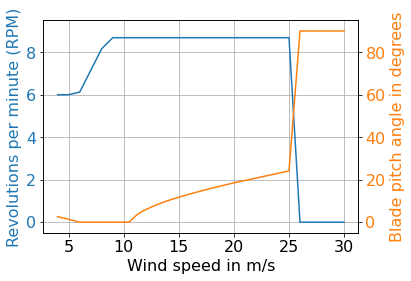

In [23]:
# print operational settings
fig, ax1 = plt.subplots()

color = 'C0'
ax1.set_xlabel("Wind speed in m/s")
ax1.set_ylabel('Revolutions per minute (RPM)', color=color)
ax1.plot(op[:,0], op[:,2], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(-0.5,9.5)

ax2 = ax1.twinx()

color = 'C1'
ax2.set_ylabel('Blade pitch angle in degrees', color=color)
ax2.plot(op[:,0], op[:,1], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(-5,95)

ax1.grid(axis="both")
plt.tight_layout()

### Results

In [38]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
%matplotlib widget

#with open("full_turbine_model_results.pkl", "rb") as f:
#    results = pickle.load(f)

font = {
        'size'   : 16}

matplotlib.rc('font', **font)

k = {
    "Torque":"MNm",
     "Thrust":"MN"
}
modes = {
         
         "CFD":{"ls":"-","c":"black","label":"Complex PBM"},
         "XFOIL+Viterna+CFD":{"ls":"-","c":"C0","label":"Simplified PBM\nwith extrapolation"},
         "PGNN+CFD":{"ls":"-","c":"C1", "label":"PGNN"},
         "WPGNN+CFD":{"ls":"--","c":"C2", "label":"Weighted PGNN"},
         "Corrective":{"ls":"--","c":"C3", "label":"Corrected PGNN"},
         "EPGNN+CFD":{"ls":"--","c":"C4", "label":"Extended PGNN"},
         "CorrectiveEx":{"ls":"--","c":"C4", "label":"Corrected Extended PGNN"},
         "DDNN+CFD":{"ls":"--","c":"C2", "label":"DDNN"},
}

op_settings = 19

print_noaf=1
print_allaf=0
tot_err={}
x="Wind"
x_unit = "m/s"
for key in k:
    tot_err[key]={}
    fig, ax = plt.subplots(2,1, figsize=(7,7), sharex=True,gridspec_kw={'height_ratios': [3, 1]})
    #fig.title(key)
    #ax[0].set_title(key)
    for mode in modes:
        if print_allaf:
            ax[0].plot(results[mode][x],np.array(results[mode][key])/1e6,
                       label=modes[mode]["label"],
                       linestyle = modes[mode]["ls"],
                       color=modes[mode]["c"])
    
        if key == "Torque" and mode != "Expected" and print_noaf==True:
            Qs = []
            for i in range(op_settings):
                Q=0
                for j in range(6,30):
                    Q+=results[mode]["Details"][i]["dQ"][j]
                Qs.append(Q)
            Qs = np.array(Qs)
            ax[0].plot(results[mode][x][:op_settings], Qs/1e6 ,
                       label=modes[mode]["label"],
                       linestyle = modes[mode]["ls"], 
                       color = modes[mode]["c"])

        elif key == "Thrust" and mode != "Expected" and print_noaf==True:
            Qs = []
            for i in range(op_settings):
                Q=0
                for j in range(6,30):
                    Q+=results[mode]["Details"][i]["dT"][j]
                Qs.append(Q)
            Qs = np.array(Qs)
            ax[0].plot(results[mode][x][:op_settings], Qs/1e6 ,
                       label=modes[mode]["label"],
                       linestyle = modes[mode]["ls"], 
                       color = modes[mode]["c"])
        
            
        
    ax[0].set_ylabel(key +" in "+ k[key])
    #ax[0].set_xlabel(x+" in " + x_unit)
    #plt.legend()
    #plt.tight_layout()
    ax[0].grid()
    
    #plt.figure()
    #plt.title(key)
    #plt.yscale("log")
    #ax[1].set_title("Residual")
    for mode in modes:
        if print_allaf:
            ax[1].plot(results[mode][x],(np.array(results[mode][key])-np.array(results["CFD"][key]))/1e6#np.array(results["CFD"][key])#1e6
                       , label=modes[mode]["label"], 
                       linestyle = modes[mode]["ls"], 
                       color=modes[mode]["c"])

        if key == "Torque" and mode != "Expected" and print_noaf==True:
            Qs = []
            for i in range(op_settings):
                Q=0
                for j in range(6,30):
                    Q+=results[mode]["Details"][i]["dQ"][j]
                Qs.append(Q)
            Qs = np.array(Qs)
            if mode == "CFD":
                Qs_ref = Qs
                
            tot_err[key][mode]=np.abs(Qs-Qs_ref).mean()/1e6
            
            ax[1].plot(results[mode][x][:op_settings],(Qs-Qs_ref)/1e6,
                       label=modes[mode]["label"],
                       linestyle = modes[mode]["ls"],
                       color = modes[mode]["c"])

        elif key == "Thrust" and mode != "Expected" and print_noaf==True:
            Qs = []
            for i in range(op_settings):
                Q=0
                for j in range(6,30):
                    Q+=results[mode]["Details"][i]["dT"][j]
                Qs.append(Q)
            Qs = np.array(Qs)
            if mode == "CFD":
                Qs_ref = Qs
            
            tot_err[key][mode]=np.abs(Qs-Qs_ref).mean()/1e6
            
            ax[1].plot(results[mode][x][:op_settings],(Qs-Qs_ref)/1e6 ,
                       label=modes[mode]["label"],
                       linestyle = modes[mode]["ls"],
                       color = modes[mode]["c"])
    
        
    #ax[1].set_ylabel("Difference "+key +" in "+ k[key])
    ax[1].set_ylabel("Residual")
    ax[1].set_xlabel(x+" in " + x_unit)
    #ax[1].legend(#loc="upper left",
               #ncol=2,
    #           fontsize=12)
    ax[0].legend(#loc="lower right",
               #ncol=2,
               fontsize=12)
    ax[1].grid()
    plt.tight_layout()
    
    def full_extent(ax, pad=0.0):
        from matplotlib.transforms import Bbox
        """Get the full extent of an axes, including axes labels, tick labels, and
        titles."""
        # For text objects, we need to draw the figure first, otherwise the extents
        # are undefined.
        ax.figure.canvas.draw()
        items = ax.get_xticklabels() + ax.get_yticklabels() 
        items += [ax, ax.title]
        items += [ax.get_xaxis().get_label(), ax.get_yaxis().get_label()]
        bbox = Bbox.union([item.get_window_extent() for item in items])
        return bbox.expanded(1.0 + pad, 1.0 + pad)
    
    plt.savefig(key+".pdf")#,dpi=600)
    #extent = full_extent(ax[0]).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(key+"_abs.png", bbox_inches=extent)
    #extent = full_extent(ax[1]).transformed(fig.dpi_scale_trans.inverted())
    #fig.savefig(key+"_residual.png", bbox_inches=extent)
    
    
    
print(tot_err)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

{'Torque': {'CFD': 0.0, 'XFOIL+Viterna+CFD': 0.3448697145086366, 'PGNN+CFD': 0.8622825453433138, 'WPGNN+CFD': 0.19722416790208216, 'Corrective': 0.06390573973105929, 'EPGNN+CFD': 0.14610318768959432, 'CorrectiveEx': 0.05928291636609872, 'DDNN+CFD': 7694.181477864526}, 'Thrust': {'CFD': 0.0, 'XFOIL+Viterna+CFD': 0.019303243435948806, 'PGNN+CFD': 0.003083666924427879, 'WPGNN+CFD': 0.0036426211101831777, 'Corrective': 0.0017294146714071485, 'EPGNN+CFD': 0.0031426868643181748, 'CorrectiveEx': 0.0013649999278078182, 'DDNN+CFD': 385.60367074647155}}


In [39]:
def r(x):
    return x
    #return np.sqrt(x)
print("Relative improvement of methods over sPBM")
print("Method & Torque & Thrust","&","Average",r"\\\hline")
for key in ["PGNN+CFD","WPGNN+CFD","Corrective","EPGNN+CFD","CorrectiveEx"]:
    print(
        modes[key]["label"], "&",
        round(r(tot_err["Torque"]["XFOIL+Viterna+CFD"])/r(tot_err["Torque"][key]),2), "&",
        round(r(tot_err["Thrust"]["XFOIL+Viterna+CFD"])/r(tot_err["Thrust"][key]),2), "&",
        round((r(tot_err["Thrust"]["XFOIL+Viterna+CFD"])/r(tot_err["Thrust"][key])+r(tot_err["Torque"]["XFOIL+Viterna+CFD"])/r(tot_err["Torque"][key]))/2,2),r"\\")


Relative improvement of methods over sPBM
Method & Torque & Thrust & Average \\\hline
PGNN & 0.4 & 6.26 & 3.33 \\
Weighted PGNN & 1.75 & 5.3 & 3.52 \\
Corrected PGNN & 5.4 & 11.16 & 8.28 \\
Extended PGNN & 2.36 & 6.14 & 4.25 \\
Corrected Extended PGNN & 5.82 & 14.14 & 9.98 \\


In [40]:
def r(x):
    return x
    #return np.sqrt(x)
print("Relative error of methods ")
print("Method & Torque & Thrust","&","Average",r"\\\hline")
for key in ["DDNN+CFD","PGNN+CFD","WPGNN+CFD","Corrective","EPGNN+CFD","CorrectiveEx"]:
    print(
        modes[key]["label"], "&",
        round(r(tot_err["Torque"][key])/r(tot_err["Torque"]["XFOIL+Viterna+CFD"]),2), "&",
        round(r(tot_err["Thrust"][key])/r(tot_err["Thrust"]["XFOIL+Viterna+CFD"]),2), "&",
        round((r(tot_err["Thrust"][key])/r(tot_err["Thrust"]["XFOIL+Viterna+CFD"])+r(tot_err["Torque"][key])/r(tot_err["Torque"]["XFOIL+Viterna+CFD"]))/2,2),r"\\")


Relative error of methods 
Method & Torque & Thrust & Average \\\hline
DDNN & 22310.4 & 19976.11 & 21143.25 \\
PGNN & 2.5 & 0.16 & 1.33 \\
Weighted PGNN & 0.57 & 0.19 & 0.38 \\
Corrected PGNN & 0.19 & 0.09 & 0.14 \\
Extended PGNN & 0.42 & 0.16 & 0.29 \\
Corrected Extended PGNN & 0.17 & 0.07 & 0.12 \\


In [171]:
to_plot=np.linspace(0,18,19, dtype=int)
modes_of_interest= [
    "PGNN+CFD",
    "CFD", 
    #"WPGNN+CFD",
    #"PGNN+DDNN",
    #"XFOIL+Viterna+DDNN"
    "DDNN",
    "IPGNN+CFD",
    #"Corrective",
    
]

c = ["blue","green","orange"]

fig, axes = plt.subplots(2,2,sharex=True,sharey=True, figsize = (8,8))
k=0
for mode in modes_of_interest:
    fig.suptitle("Torque absolute")
    axes[int(k/2),k%2].set_title(mode)
    j=1
    for i in to_plot:
        axes[int(k/2),k%2].plot(
            np.linspace(0,29,30),#-0.4 + j/len(modes_of_interest)*0.8,
            results[mode]["Details"][i]["dQ"]/results["CFD"]["Torque"][i],
            #alpha = 0.8/j,
            #alpha = 0.5,
            #width=0.8/len(modes_of_interest),
            label=str(op[i,0])+"m/s",
            color="C"+str(j-1),
            #fill=False
            
        )
        #axes[int(k/2),k%2].plot(results[mode]["Details"][i]["Cl"], linestyle="--", color="C"+str(j-1))
        #axes[int(k/2),k%2].plot(results[mode]["Details"][i]["Cd"]*3, linestyle=":", color="C"+str(j-1))
        
        j+=1
        
    #axes[int(k/2),k%2].plot([0],[0],label="Lift", linestyle="--", color="black") 
    #axes[int(k/2),k%2].plot([0],[0],label="Drag", linestyle = ":", color="black")
    #axes[int(k/2),k%2].plot([0],[0],label=" ", color="white")
    
    axes[int(k/2),k%2].plot([5.5,5.5],[-0.05,0.1],color="black",linestyle = ":",label="method switch")
    axes[int(k/2),k%2].grid()
    #axes[int(k/2),k%2].legend(loc="lower center", ncol=2)
    if k>1:
        axes[int(k/2),k%2].set_xlabel("airfoils")
    #if k%2==0:
        #axes[int(k/2),k%2].set_ylabel("% contribution")
       # axes[int(k/2),k%2].set_ylabel("Torque in MNm")
    k+=1
    
fig, axes = plt.subplots(2,2,sharex=True,sharey=True, figsize = (8,8))
k=0
for mode in modes_of_interest:
    fig.suptitle("Torque error")
    axes[int(k/2),k%2].set_title(mode)
    j=1
    for i in to_plot:
        axes[int(k/2),k%2].plot(
            np.linspace(0,29,30),#-0.5 + j/(len(modes_of_interest)-1)*1,
            (results[mode]["Details"][i]["dQ"]-results["CFD"]["Details"][i]["dQ"])/np.abs(results[mode]["Torque"][i]-results["CFD"]["Torque"][i]),
            #alpha = 1/j,
            #width=1/len(modes_of_interest),
            #label=str(op[i,0])+"m/s",
            color="C"+str(j-1)
        )
        #plt.plot([-1,30],[0,0],color="black")
        j+=1
    
    
    axes[int(k/2),k%2].plot([5.5,5.5],[-0.25,1.25],color="black",linestyle = ":",label="method switch")
    axes[int(k/2),k%2].legend(loc="upper center")
    axes[int(k/2),k%2].grid()
    
    if k>1:
        axes[int(k/2),k%2].set_xlabel("airfoils")
    if k%2==0:
        #axes[int(k/2),k%2].set_ylabel("% contribution")
        axes[int(k/2),k%2].set_ylabel("Relative contribution to the total error")
    
    k+=1
    

    
# Thrust    

fig, axes = plt.subplots(2,2,sharex=True,sharey=True, figsize = (8,8))
k=0
for mode in modes_of_interest:
    fig.suptitle("Thrust absolute")
    axes[int(k/2),k%2].set_title(mode)
    j=1
    for i in to_plot:
        axes[int(k/2),k%2].plot(
            np.linspace(0,29,30),#-0.4 + j/len(modes_of_interest)*0.8,
            results[mode]["Details"][i]["dT"]/results["CFD"]["Torque"][i],
            #alpha = 0.8/j,
            #alpha = 0.5,
            #width=0.8/len(modes_of_interest),
            label=str(op[i,0])+"m/s",
            color="C"+str(j-1),
            #fill=False
            
        )
        #axes[int(k/2),k%2].plot(results[mode]["Details"][i]["Cl"], linestyle="--", color="C"+str(j-1))
        #axes[int(k/2),k%2].plot(results[mode]["Details"][i]["Cd"]*3, linestyle=":", color="C"+str(j-1))
        
        j+=1
        
    #axes[int(k/2),k%2].plot([0],[0],label="Lift", linestyle="--", color="black") 
    #axes[int(k/2),k%2].plot([0],[0],label="Drag", linestyle = ":", color="black")
    #axes[int(k/2),k%2].plot([0],[0],label=" ", color="white")
    
    axes[int(k/2),k%2].plot([5.5,5.5],[-0.05,0.1],color="black",linestyle = ":",label="method switch")
    axes[int(k/2),k%2].grid()
    #axes[int(k/2),k%2].legend(loc="lower center", ncol=2)
    if k>1:
        axes[int(k/2),k%2].set_xlabel("airfoils")
    #if k%2==0:
        #axes[int(k/2),k%2].set_ylabel("% contribution")
       # axes[int(k/2),k%2].set_ylabel("Torque in MNm")
    k+=1
    
    
fig, axes = plt.subplots(2,2,sharex=True,sharey=True, figsize = (8,8))
k=0
for mode in modes_of_interest:
    fig.suptitle("Thrust error")
    axes[int(k/2),k%2].set_title(mode)
    j=1
    for i in to_plot:
        axes[int(k/2),k%2].plot(
            np.linspace(0,29,30),#-0.5 + j/(len(modes_of_interest)-1)*1,
            (results[mode]["Details"][i]["dT"]-results["CFD"]["Details"][i]["dQ"])/np.abs(results[mode]["Torque"][i]-results["CFD"]["Torque"][i]),
            #alpha = 1/j,
            #width=1/len(modes_of_interest),
            #label=str(op[i,0])+"m/s",
            color="C"+str(j-1)
        )
        #plt.plot([-1,30],[0,0],color="black")
        j+=1
    
    
    axes[int(k/2),k%2].plot([5.5,5.5],[-0.25,1.25],color="black",linestyle = ":",label="method switch")
    axes[int(k/2),k%2].legend(loc="upper center")
    axes[int(k/2),k%2].grid()
    
    if k>1:
        axes[int(k/2),k%2].set_xlabel("airfoils")
    if k%2==0:
        #axes[int(k/2),k%2].set_ylabel("% contribution")
        axes[int(k/2),k%2].set_ylabel("Relative contribution to the total error")
    
    k+=1
    


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [194]:
plt.figure( figsize=(6,6))
blade_twist=[]
with open("AeroDyn_File.txt","r") as f:
    i=0
    for line in f:
        if i>5:
            line = line.split()
            #blade_section += int(line[6])
            #blade_span += float(line[0])
            #blade_chord += float(line[5])
            blade_twist += [float(line[4])]
        i+=1
        
        
def norm(alpha):
    x=[]
    for i in range(len(alpha)):
        x.append(atan2(sin(alpha[i]*np.pi/180), cos(alpha[i]*np.pi/180))*180/np.pi)
    return np.array(x)
     
    
op_set=9
    
cl_interp = []
cd_interp = []
cl_airfoil_func = []
#print(results["CFD"]["Details"][op_set]["AoA"])
for i in range(0,30):
    cl_interp.append(interp1d(data[i]["alpha"],
                                                data[i]["Cl_target"],kind="quadratic",
                    )(norm([results["CFD"]["Details"][op_set]["AoA"][i]])[0]))#+180)%360-180))
    #cd_interp.append(interp1d(data[i]["alpha"],
    #                                            data[i]["Cd_target"],kind="quadratic",
    #                )(norm(results["CFD"]["Details"][op_set]["AoA"])))#+180)%360-180))

    #cl_airfoil_func.append(temp_airfoil_functions[i+op_set*30](results["CFD"]["Details"][op_set]["AoA"][i]%180))
    #cd_airfoil 
plt.plot(np.array(cl_interp),label = "input_Cl")
plt.plot(results["CFD"]["Details"][op_set]["Cl"], label= "output_Cl",linestyle = "--")
plt.ylim(-1,3)
x = []
for i in range(30):
    x.append(tempitemp[i][0](norm([results["CFD"]["Details"][op_set]["AoA"][i]])[0]))
plt.plot(x,label="loadfunction_Cl")
#for i in range(0,30):
#plt.plot(interp1d(tempitetempitemp[i][0],
#                                                tempitetempitemp[i][1],kind="quadratic")
#                    (norm(results["CFD"]["Details"][op_set]["AoA"])))

plt.plot(cl_airfoil_func, label= "function_Cl",linestyle = "--")
temp2=[]
for key in temp:
    temp2.append(temp[key])
temp2=np.array(temp2)
plt.plot(temp2[:,op_set,1],label = "final_extracted_Cl", linestyle = ":")                          
plt.title("Cl")
plt.legend()
plt.tight_layout()

plt.figure()
plt.plot((results["CFD"]["Details"][op_set]["AoA"]+180)%360-180)


plt.figure()
for i in range(6,len(data)):
    plt.plot(data[i]["alpha"],data[i]["Cl_target"], color="C"+str(i-6))
    plt.plot(data[i]["alpha"],data[i]["Cl_approx_exp"],linestyle = "--",color="C"+str(i-6))
'''
plt.figure()
plt.plot(np.array(cd_interp)[:,op_set],label = "input_Cd")
plt.plot(results["CFD"]["Details"][op_set]["Cd"], label= "output_Cd",linestyle = "--")
plt.plot(np.array(cd_interp_norm)[:,op_set],label = "norm_Cd", linestyle = ":")                          
plt.title("Cd")
plt.legend()
plt.tight_layout()

plt.figure()
plt.title("twist")
plt.plot(np.array(blade_twist+op[op_set,1]))
plt.plot(results["CFD"]["Details"][op_set]["pitch"]*180/np.pi, linestyle = "--")
'''

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

'\nplt.figure()\nplt.plot(np.array(cd_interp)[:,op_set],label = "input_Cd")\nplt.plot(results["CFD"]["Details"][op_set]["Cd"], label= "output_Cd",linestyle = "--")\nplt.plot(np.array(cd_interp_norm)[:,op_set],label = "norm_Cd", linestyle = ":")                          \nplt.title("Cd")\nplt.legend()\nplt.tight_layout()\n\nplt.figure()\nplt.title("twist")\nplt.plot(np.array(blade_twist+op[op_set,1]))\nplt.plot(results["CFD"]["Details"][op_set]["pitch"]*180/np.pi, linestyle = "--")\n'